In [104]:
import torch
import gpytorch
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
import pickle
import anndata
import os,sys,inspect
import scanpy as sc

# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 

# new source imports 
import Main
import ClusterUtils
import TimeSeriesPreprocessor
import warnings
import pickle
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [146]:
adata = sc.read_h5ad("match_accuracy_pancreas.h5ad")

In [147]:
adata 

AnnData object with n_obs × n_vars = 1845 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'dpt_pseudotime', 'time', 'terminal_states', 'terminal_states_probs', 'time_bins'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mean_gex', 'frac_cells', 'Beta_corr', 'Beta_pval', 'Beta_qval', 'Beta_ci_low', 'Beta_ci_high', 'simulation_gene'
    uns: 'clusters_colors', 'clusters_fine_colors', 'coarse_fwd', 'diffmap_evals', 'eigendecomposition_fwd', 'iroot', 'louvain_Alpha_colors', 'louvain_Beta_co

### Code from Emma Dann to simulate artificial perturbations under the 2 perturbation scenarios (deleting or changing the start portion of a query gene trajectory)


In [4]:
def simulate_alignment2(adata, true_align_string, 
                       frac_query = 0.5,
                       seed=42352,
                       gene = 'Msi1',
                       n_stds = 1):
    np.random.seed(seed)
    n_bins=len(true_align_string)
    adata.obs['time_bins'] = pd.cut(adata.obs['time'], n_bins).astype('category').cat.codes
    q_cells= np.array([])

    ## Split in ref and query
    for i,b in enumerate(true_align_string):
        
        n_cells = sum(adata.obs['time_bins'] == i)
       # print(n_cells, frac_query)
        q_cells_bin = np.random.choice(adata.obs_names[adata.obs['time_bins'] == i], size=int(np.round(n_cells*frac_query)), replace=False)
        q_cells = np.hstack([q_cells, q_cells_bin])
   # print('****')
    adata_query = adata[q_cells].copy()
    adata_ref = adata[~adata.obs_names.isin(q_cells)].copy()
    
    ## Calculate shift for insertion
    X_query = adata_query.X.copy()
    X_gene = X_query[:,adata_query.var_names == gene]
    ins_shift = n_stds*X_gene.std()
    
    for i,b in enumerate(true_align_string):
        bcells = adata_query.obs_names[adata_query.obs['time_bins'] == i]
        if b == 'D': ## delete cells
            adata_query = adata_query[~adata_query.obs_names.isin(bcells)].copy()
        if b == 'I': # change values for gene expression            
            X_query = adata_query.X.copy()
            X_gene = X_query[adata_query.obs_names.isin(bcells),adata_query.var_names == gene]
            X_query[adata_query.obs_names.isin(bcells),adata_query.var_names == gene] = X_gene + ins_shift
            adata_query.X = X_query.copy()
    
    # Algorithm expect time spanning from 0 to 1
    adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(adata_ref.obs['time'].values)
    adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(adata_query.obs['time'].values)

    # adata_query.obs.loc[adata_query.obs['time'].idxmax(), 'time'] = 1.0
    return(adata_ref, adata_query)


def make_align_string(mm_type, mm_start = 10, n_bins = 40, mm_size=10):
    mm_ixs = range(mm_start, mm_start+mm_size)
    true_align_string = ''.join([mm_type if i in mm_ixs else 'M' for i in range(n_bins)])
    return(true_align_string)

def predict_alignment(adata_ref, adata_query, gene, n_bins=50):
    gene_list = adata_ref.var_names 
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, n_bins)
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE = 0.1
    al_obj = aligner.align_single_pair(gene)
    return aligner, al_obj

In [5]:
adata = sc.read_h5ad("match_accuracy_pancreas.h5ad")
genes = pd.read_csv('SimExperiment2_genelist.csv')
genes = list(genes.gene) #769 genes

In [6]:
len(genes) #769

769

# Creating perturbed datasets

In [7]:
# perturbed data generation - deleted case (perturbation scenario 1)
#mm_sizes = [0,1,3,5,10,15,20]
import scanpy as sc
adata = sc.read_h5ad("match_accuracy_pancreas.h5ad")
genes = pd.read_csv('sim2_genelist')
genes = list(genes.gene)

for MM_SIZE in [20]:
    print('MM_SIZE= ', MM_SIZE)
    rmat = []
    qmat = []
    r_time = None
    q_time = None

    for g in tqdm(genes):
            align_params = {'mm_type':'D', 'n_bins':50, 'mm_start':0, 'mm_size': MM_SIZE}
            true_align_string = make_align_string(**align_params)
            rdata, qdata = simulate_alignment2(adata, true_align_string, gene=g)
            
            r_time = np.asarray(rdata.obs.time)
            q_time = np.asarray(qdata.obs.time)
            rdata = np.asarray(rdata[:,g].X).flatten()
            rmat.append(rdata)
            qdata = np.asarray(qdata[:,g].X).flatten()
            qmat.append(qdata)

    ref_data = pd.DataFrame(rmat).transpose()
    ref_data.columns = genes
    query_data = pd.DataFrame(qmat).transpose()
    query_data.columns = genes
    adata_ref = anndata.AnnData(ref_data)
    adata_ref.var_names = list(ref_data.columns)
    adata_ref.obs['time'] = r_time
    adata_query = anndata.AnnData(query_data)
    adata_query.var_names = list(query_data.columns)
    adata_query.obs['time'] = q_time
    
    adata_ref.write_h5ad('ref_adata_D_size'+str(MM_SIZE)+'.h5ad')
    adata_query.write_h5ad('query_adata_D_size'+str(MM_SIZE)+'.h5ad')
    break

MM_SIZE=  20


100%|██████████| 769/769 [15:23<00:00,  1.20s/it]


In [13]:
# perturbed data generation - changed case (perturbation scenario 2)
for MM_SIZE in [0,1,3,5,10,15,20]:
    print('MM_SIZE= ', MM_SIZE)
    rmat = []
    qmat = []
    r_time = None
    q_time = None

    for g in tqdm(genes):
            align_params = {'mm_type':'I', 'n_bins':50, 'mm_start':0, 'mm_size': MM_SIZE}
            true_align_string = make_align_string(**align_params)
            rdata, qdata = simulate_alignment2(adata, true_align_string, gene=g)
            
            r_time = np.asarray(rdata.obs.time)
            q_time = np.asarray(qdata.obs.time)
            rdata = np.asarray(rdata[:,g].X).flatten()
            rmat.append(rdata)
            qdata = np.asarray(qdata[:,g].X).flatten()
            qmat.append(qdata)

    ref_data = pd.DataFrame(rmat).transpose()
    ref_data.columns = genes
    query_data = pd.DataFrame(qmat).transpose()
    query_data.columns = genes
    adata_ref = anndata.AnnData(ref_data)
    adata_ref.var_names = list(ref_data.columns)
    adata_ref.obs['time'] = r_time
    adata_query = anndata.AnnData(query_data)
    adata_query.var_names = list(query_data.columns)
    adata_query.obs['time'] = q_time
    
    adata_ref.write_h5ad('ref_adata_I_size'+str(MM_SIZE)+'.h5ad')
    adata_query.write_h5ad('query_adata_I_size'+str(MM_SIZE)+'.h5ad')


MM_SIZE=  3


100%|██████████| 769/769 [02:13<00:00,  5.77it/s]


MM_SIZE=  5


100%|██████████| 769/769 [02:18<00:00,  5.56it/s]


MM_SIZE=  10


100%|██████████| 769/769 [02:30<00:00,  5.11it/s]


MM_SIZE=  15


100%|██████████| 769/769 [02:42<00:00,  4.73it/s]


# Running G2G on perturbed datasets

In [8]:
import torch
import gpytorch
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
import pickle
import anndata
import os,sys,inspect
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 
# new source imports 
import Main
import ClusterUtils
import VisualUtils
import warnings
import pickle
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


# Following function is run for each case and each size separately
def run_g2g_and_save_aligner(dataset_id):
    adata_ref = anndata.read_h5ad('ref_adata_'+dataset_id+'.h5ad')
    adata_query = anndata.read_h5ad('query_adata_'+dataset_id+'.h5ad')

    gene_list= list(adata_ref.var_names) 
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, 50)
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.align_all_pairs()

    # Run clustering and then save each aligner object
    ClusterUtils.run_hierarchical_clustering_with_binary_encode_alignment_path_hamming(aligner, DIST_THRESHOLD=0.2)
    pickle.dump(aligner, open('aligner_'+dataset_id+'.pkl', 'wb')) 
    
#for mm_size in [0,1,3,5,10,15,20]:
#    run_g2g_and_save_aligner("D_"+str(mm_size))

#for mm_size in [0,1,3,5,10,15,20]:
#    run_g2g_and_save_aligner("I_"+str(mm_size))



# G2G analysis

In [1]:
import torch
import gpytorch
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
import pickle
import anndata
import os,sys,inspect
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 
# new source imports 
import Main
import ClusterUtils
import VisualUtils
import warnings
import pickle
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


aligners = {}
adatasets = {}

for mm_size in tqdm([0,1,3,5,10,15,20]):
    
    for ptype in ['I','D']:
        dataset_id = ptype +'_size'+str(mm_size)

        adata_ref = anndata.read_h5ad('ref_adata_'+dataset_id+'.h5ad')
        adata_query = anndata.read_h5ad('query_adata_'+dataset_id+'.h5ad')
        with open('aligner_'+dataset_id+'.pkl', 'rb') as f:
            aligners[dataset_id] = pickle.load(f)
        adatasets[dataset_id] = [adata_ref, adata_query]
    
    


100%|██████████| 7/7 [14:13<00:00, 121.99s/it]


In [3]:
genes = pd.read_csv('sim2_genelist')
gene_list = list(genes.gene) #769 genes

In [52]:
def plot_aggregate_alignment(adata_ref, adata_query, aligner, plot=False):

    vs = VisualUtils.VisualUtils(adata_ref, adata_query, cell_type_colname = 'time', 
                    S_len=len(aligner.results[0].S.time_points), 
                    T_len=len(aligner.results[0].T.time_points), 
                    titleS='(Reference)', titleT='(Query)',
                    write_file=False)


    #overall_alignment, alignment_path =vs.compute_overall_alignment(aligner)
    overall_alignment, alignment_path =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_list)

    mat = aligner.get_pairwise_match_count_mat()
    if(plot):
        plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat)
    return overall_alignment


def plot_alignment_path_on_given_matrix(mat, paths, cmap='viridis'):
            fig,ax = plt.subplots(1,1, figsize=(7,7))
            sb.heatmap(mat, square=True,  cmap='viridis', ax=ax, cbar=True)  
            for path in paths: 
                path_x = [p[0]+0.5 for p in path]
                path_y = [p[1]+0.5 for p in path]
                ax.plot(path_y, path_x, color='white', linewidth=6)
            plt.xlabel("(Reference)",fontweight='bold')
            plt.ylabel("(Query)",fontweight='bold')
            ax.xaxis.tick_top() # x axis on top
            ax.xaxis.set_label_position('top')

    #plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat, annot=False)


def get_start_mismatch_counts(aligner):
    mm_counts = []
    for g in gene_list:
        if(g=='Gpr179'):
            continue
        al_str = aligner.results_map[g].alignment_str
        mismatch_count = 0
        for c in al_str:
            if(c in ['I','D']):
                mismatch_count+=1
            else:
                break
        mm_counts.append(mismatch_count)
    return mm_counts
    
def get_results(dtype, size):
    dataset_id = dtype+'_size'+str(size)
    aligner = aligners[dataset_id]
    adata_ref = adatasets[dataset_id][0]
    adata_query = adatasets[dataset_id][1]
    
    aggregate_alignment = plot_aggregate_alignment(adata_ref, adata_query,  aligner)
    print(aggregate_alignment)
    mm_lengths = get_start_mismatch_counts(aligner)
    #sb.violinplot(mm_lengths)
    return mm_lengths
    
    
start_mm_lengths = []
labels = []
for mm_size in [0,1,3,5,10,15,20]:
    temp = get_results('I', mm_size)
    start_mm_lengths += temp
    labels+= list(np.repeat(mm_size, len(temp)))


MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM
MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM
IIIIIIDDDDMDMMMMMMMMMMMMMDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM
IIIIIIIIIIIIDDDDMDDDDMWWWMMMMMMDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM
IIIIIIIIIIIIIIIIDDDMDMDMMDDDDDDDDMMWWWMMMMMMMMMMMMMMMMMMMMMMMMMMMM
IIIIIIIIIIIIIIIIIIIIIDDDMDDMDDDDDDDDDDDDDWWWMMMMMMMMMMMMMMMMMMMMMMMMMMM
IIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDMMWMMMMMMMMMMMMMMMMMMMMMMMMM


91.19741222366713 100.0
90.63669700910282 98.0
77.78759427828366 94.0
70.18738621586472 90.0
64.45820546163834 80.0
59.686501950584955 70.0
52.413745123537154 60.0


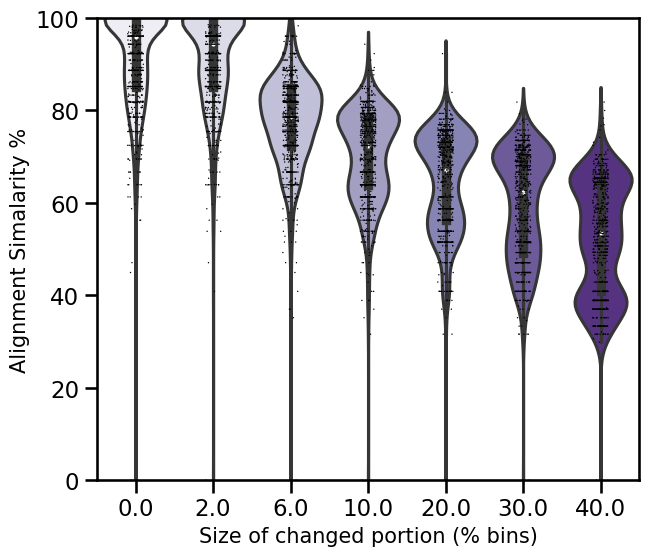

In [79]:
def compute_stat(aligner, size):

    k = []
    temp = [] 
    temp_i = []; temp_d = []
    z = []
    for a in aligner.results:
        k.append(a.get_series_match_percentage()[0])
        z.append(a.gene)
        t=0
        t_i = 0; t_d =0
        for c in a.alignment_str:
            if(c in ['I','D']):
                t+=1
                if(c=='I'):
                    t_i+=1
                else:
                    t_d+=1
            else:
                break
        temp.append(t)
        temp_i.append(t_i)
        temp_d.append(t_d)

    size_label = np.repeat((size*100/50),len(temp))
    
    
    
    intermediate_mismatches = [] 
    for a in aligner.results:
        x = a.alignment_str
        x = x[x.find('M'):len(x)]
        intermediate_mm = 0
        intermediate_mm += x.count('I')
        intermediate_mm += x.count('D')
        intermediate_mismatches.append(intermediate_mm)
    

    d = pd.DataFrame([z,temp,temp_i,temp_d, intermediate_mismatches, k, size_label]).transpose()
    d.columns = ['gene','mm_count','start_Is','start_Ds','intermediate_mm_count','sim','size']
    return d

d0 = compute_stat(aligners['I_size0'],0)
d1 = compute_stat(aligners['I_size1'],1)
d3 = compute_stat(aligners['I_size3'],3)
d5 = compute_stat(aligners['I_size5'],5)
d10 = compute_stat(aligners['I_size10'],10)
d15 = compute_stat(aligners['I_size15'],15)
d20 = compute_stat(aligners['I_size20'],20)

df = pd.DataFrame(np.vstack([d0,d1,d3,d5,d10,d15,d20])) 
df.columns= ['gene','mm_count','start_Is','start_Ds','intermediate_mm_count','sim','size']
df['sim'] = df['sim'].astype('float')
df['mm_count'] = df['mm_count'].astype('float')
df['intermediate_mm_count'] = df['intermediate_mm_count'].astype('float')

sb.set_context("talk")
with plt.rc_context({'figure.figsize':[7,6]}):

    sb.violinplot(x= 'size', y='sim', data= df, cut=True, scale='width', palette='Purples')
    sb.stripplot(data=df, x='size', y='sim', color='black', s=1);
    plt.ylabel('Alignment Simalarity %', fontsize=15)
    plt.xlabel('Size of changed portion (% bins)',  fontsize=15)
    plt.ylim(0,100.0);

# average similarity percentage across groups and their expected similarity percentage 
print(np.mean(d0['sim']), 100-(0*100/50))
print(np.mean(d1['sim']), 100-(1*100/50))
print(np.mean(d3['sim']), 100-(3*100/50))
print(np.mean(d5['sim']), 100-(5*100/50))
print(np.mean(d10['sim']), 100-(10*100/50))
print(np.mean(d15['sim']), 100-(15*100/50))
print(np.mean(d20['sim']), 100-(20*100/50))



In [80]:
p1 = list(d0['sim']) + list(d1['sim']) + list(d3['sim'])+ list(d5['sim'])

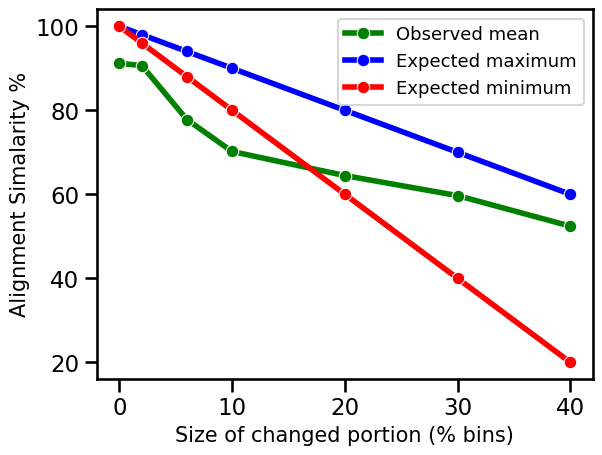

In [57]:
# how mean alignment similarity changes with the expected
mean_sim_percents= [np.mean(d0['sim']),
np.mean(d1['sim']),
np.mean(d3['sim']), 
np.mean(d5['sim']),
np.mean(d10['sim']),
np.mean(d15['sim']),
np.mean(d20['sim'])]

# if only the changed part is a insert/delete and rest gets matched
expected_sim_percents = [100-(0*100/50),
100-(1*100/50),
100-(3*100/50),
100-(5*100/50),
100-(10*100/50),
100-(15*100/50),
100-(20*100/50)]

#if both changed trajectory part and respective start of the other trajectory gets mismatched
expected_sim_percents_max = [(100-(0*100/50)),
(100-(1*2*100/50)),
(100-(3*2*100/50)),
(100-(5*2*100/50)),
(100-(10*2*100/50)),
(100-(15*2*100/50)),
(100-(20*2*100/50))]

perturbed_percents = []
for x in [0,1,3,5,10,15,20]:
    perturbed_percents.append(x*100/50)
    
sb.lineplot(perturbed_percents,mean_sim_percents,color='green', linewidth=4, marker="o")
sb.lineplot(perturbed_percents,expected_sim_percents, color ='blue',linewidth=4,marker="o")
sb.lineplot(perturbed_percents,expected_sim_percents_max, color ='red',linewidth=4,marker="o")
plt.legend(['Observed mean','Expected maximum','Expected minimum' ], fontsize=13)
plt.ylabel('Alignment Simalarity %', fontsize=15)
plt.xlabel('Size of changed portion (% bins)',  fontsize=15)
plt.savefig('simexp2_legend_for_change.png')

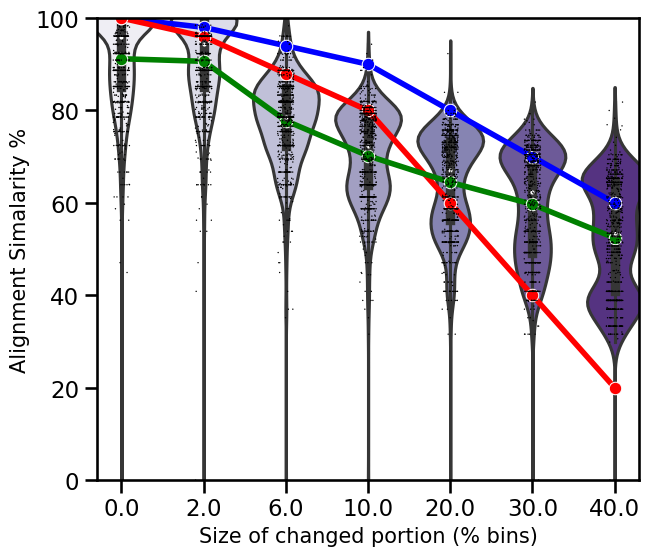

In [58]:
d1 = pd.DataFrame([['0.0', '2.0', '6.0', '10.0', '20.0', '30.0', '40.0'],expected_sim_percents ]).transpose()
d1.columns = ['size','expected_max']

d2 = pd.DataFrame([['0.0', '2.0', '6.0', '10.0', '20.0', '30.0', '40.0'],expected_sim_percents_max]).transpose()
d2.columns = ['size','expected_min']

d3 = pd.DataFrame([['0.0', '2.0', '6.0', '10.0', '20.0', '30.0', '40.0'],mean_sim_percents]).transpose()
d3 .columns = ['size','mean']

sb.set_context("talk")
with plt.rc_context({'figure.figsize':[7,6]}):

    sb.violinplot(x= 'size', y='sim', data= df, cut=True, scale='width', palette='Purples')
    sb.stripplot(data=df, x='size', y='sim', color='black', s=1);
    sb.lineplot( data=d1,x='size',y='expected_max', color ='blue',linewidth=4,marker="o")
    sb.lineplot( data=d2,x='size',y='expected_min', color ='red',linewidth=4,marker="o")
    sb.lineplot( data=d3,x='size',y='mean', color ='green',linewidth=4,marker="o")
    plt.ylabel('Alignment Simalarity %', fontsize=15)
    plt.xlabel('Size of changed portion (% bins)',  fontsize=15)
    plt.ylim(0,100.0);
    plt.savefig('simexp2_new_changedPerturb_simpercentages.png')

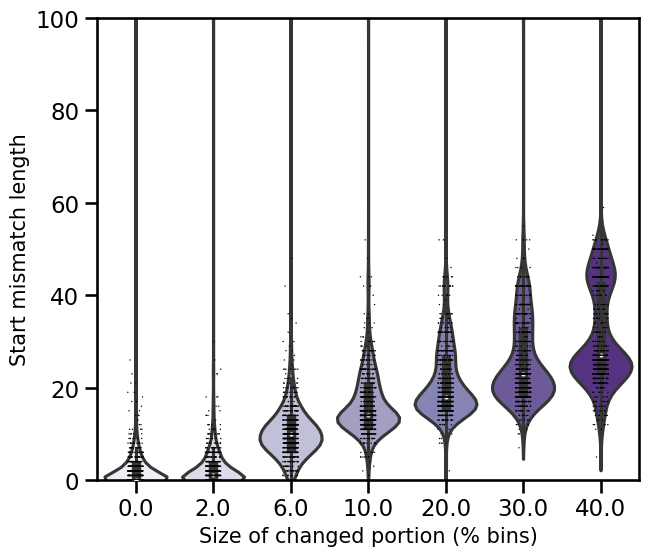

In [59]:
sb.set_context("talk")
with plt.rc_context({'figure.figsize':[7,6]}):

    sb.violinplot(x= 'size', y='mm_count', data= df, cut=True, scale='width', palette='Purples')
    sb.stripplot(data=df, x='size', y='mm_count', color='black', s=1);
    plt.ylabel('Start mismatch length', fontsize=15)
    plt.xlabel('Size of changed portion (% bins)',  fontsize=15)
    plt.ylim(0,100.0);
    plt.savefig('simexp2_new_changedPerturb_mm_counts1.png')

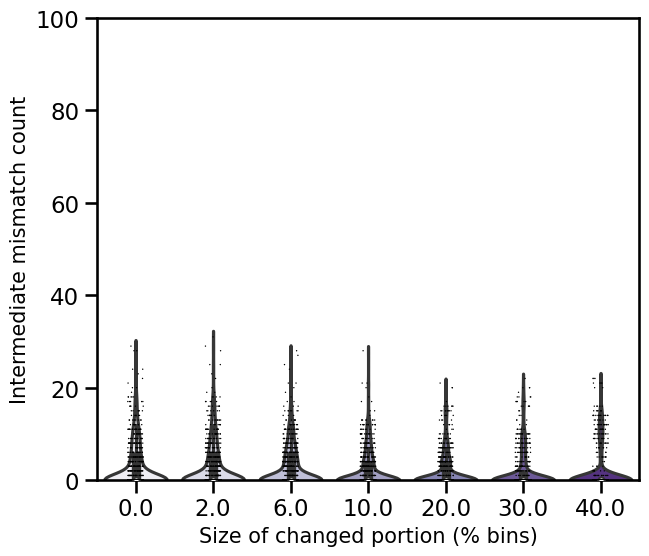

In [60]:
sb.set_context("talk")
with plt.rc_context({'figure.figsize':[7,6]}):

    sb.violinplot(x= 'size', y='intermediate_mm_count', data= df, cut=True, scale='width', palette='Purples')
    sb.stripplot(data=df, x='size', y='intermediate_mm_count', color='black', s=1);
    plt.ylabel('Intermediate mismatch count', fontsize=15)
    plt.xlabel('Size of changed portion (% bins)',  fontsize=15)
    plt.ylim(0,100.0);
    plt.savefig('simexp2_new_changedPerturb_mm_counts2.png')

91.19741222366713 100.0
90.92546163849163 98.0
89.24940182054634 94.0
84.78496749024715 90.0
77.26219765929773 80.0
77.8784655396619 70.0
76.69671001300395 60.0


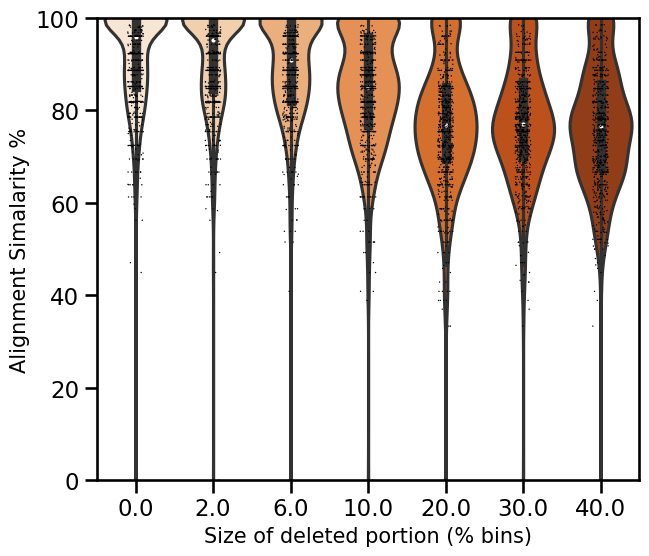

In [81]:
d0 = compute_stat(aligners['D_size0'],0)
d1 = compute_stat(aligners['D_size1'],1)
d3 = compute_stat(aligners['D_size3'],3)
d5 = compute_stat(aligners['D_size5'],5)
d10 = compute_stat(aligners['D_size10'],10)
d15 = compute_stat(aligners['D_size15'],15)
d20 = compute_stat(aligners['D_size20'],20)

df = pd.DataFrame(np.vstack([d0,d1,d3,d5,d10,d15,d20])) 
df.columns= ['gene','mm_count','start_Is','start_Ds','intermediate_mm_count','sim','size']
df['sim'] = df['sim'].astype('float')
df['mm_count'] = df['mm_count'].astype('float')
df['intermediate_mm_count'] = df['intermediate_mm_count'].astype('float')

sb.set_context("talk")
with plt.rc_context({'figure.figsize':[7,6]}):
    sb.violinplot(x= 'size', y='sim', data= df,cut=True, scale='width', palette='Oranges')
    sb.stripplot(data=df, x='size', y='sim', color='black', s=1);
    plt.ylabel('Alignment Simalarity %', fontsize=15)
    plt.xlabel('Size of deleted portion (% bins)',  fontsize=15)
    plt.ylim(0,100.0);

# average similarity percentage across groups and their expected similarity percentage 
print(np.mean(d0['sim']), 100-(0*100/50))
print(np.mean(d1['sim']), 100-(1*100/50))
print(np.mean(d3['sim']), 100-(3*100/50))
print(np.mean(d5['sim']), 100-(5*100/50))
print(np.mean(d10['sim']), 100-(10*100/50))
print(np.mean(d15['sim']), 100-(15*100/50))
print(np.mean(d20['sim']), 100-(20*100/50))

In [82]:
p2 = list(d0['sim']) + list(d1['sim']) + list(d3['sim'])+ list(d5['sim'])

In [85]:
np.mean(p1+p2)

85.74579161248374

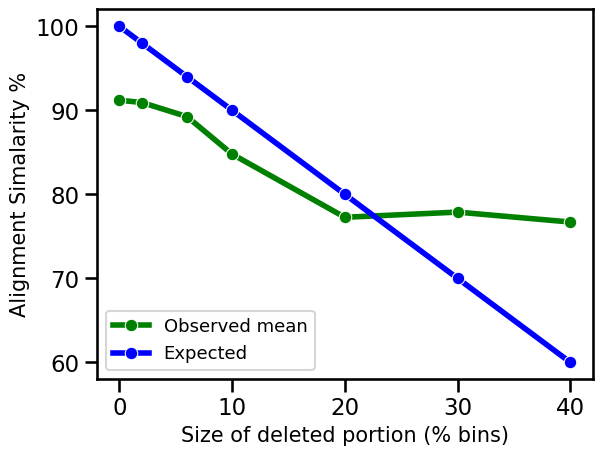

In [62]:
# how mean alignment similarity changes with the expected
mean_sim_percents= [np.mean(d0['sim']),
np.mean(d1['sim']),
np.mean(d3['sim']), 
np.mean(d5['sim']),
np.mean(d10['sim']),
np.mean(d15['sim']),
np.mean(d20['sim'])]

expected_sim_percents = [100-(0*100/50),
100-(1*100/50),
100-(3*100/50),
100-(5*100/50),
100-(10*100/50),
100-(15*100/50),
100-(20*100/50)]

perturbed_percents = []
for x in [0,1,3,5,10,15,20]:
    perturbed_percents.append(x*100/50)
    
sb.lineplot(perturbed_percents,mean_sim_percents,color='green', linewidth=4, marker="o")
sb.lineplot(perturbed_percents,expected_sim_percents, color ='blue',linewidth=4,marker="o")
plt.legend(['Observed mean','Expected' ], fontsize=13, loc='lower left')
plt.ylabel('Alignment Simalarity %', fontsize=15)
plt.xlabel('Size of deleted portion (% bins)',  fontsize=15)
plt.savefig('simexp2_legend_for_delete.png')

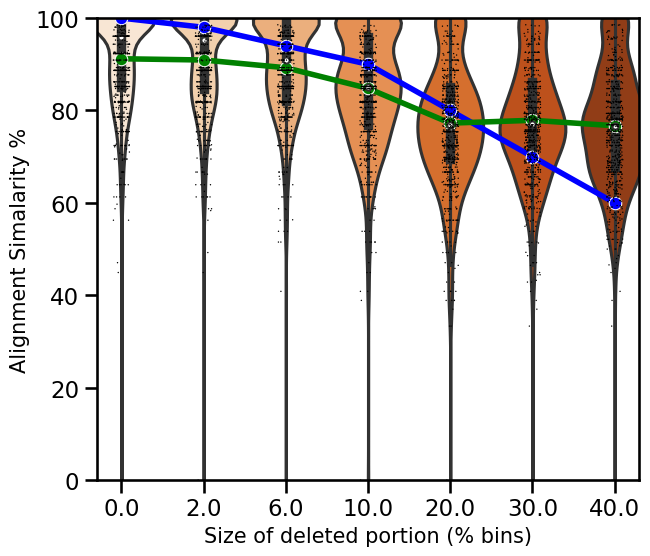

In [63]:
d1 = pd.DataFrame([['0.0', '2.0', '6.0', '10.0', '20.0', '30.0', '40.0'],expected_sim_percents ]).transpose()
d1.columns = ['size','expected']


d3 = pd.DataFrame([['0.0', '2.0', '6.0', '10.0', '20.0', '30.0', '40.0'],mean_sim_percents]).transpose()
d3 .columns = ['size','mean']

sb.set_context("talk")
with plt.rc_context({'figure.figsize':[7,6]}):

    sb.violinplot(x= 'size', y='sim', data= df, cut=True, scale='width', palette='Oranges')
    sb.stripplot(data=df, x='size', y='sim', color='black', s=1);
    sb.lineplot( data=d1,x='size',y='expected', color ='blue',linewidth=4,marker="o")
    sb.lineplot( data=d3,x='size',y='mean', color ='green',linewidth=4,marker="o")
    plt.ylabel('Alignment Simalarity %', fontsize=15)
    plt.xlabel('Size of deleted portion (% bins)',  fontsize=15)
    plt.ylim(0,100.0);
    plt.savefig('simexp2_new_deletePerturb_simpercentages.png')
    

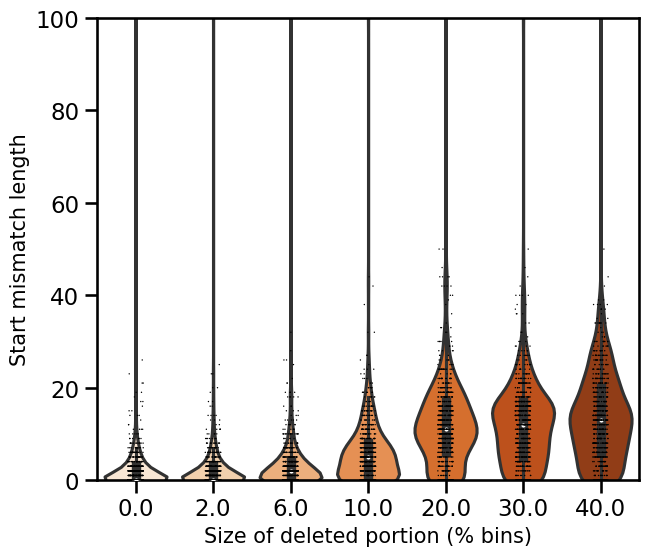

In [64]:
sb.set_context("talk")
with plt.rc_context({'figure.figsize':[7,6]}):

    sb.violinplot(x= 'size', y='mm_count', data= df, cut=True, scale='width', palette='Oranges')
    sb.stripplot(data=df, x='size', y='mm_count', color='black', s=1);
    plt.ylabel('Start mismatch length', fontsize=15)
    plt.xlabel('Size of deleted portion (% bins)',  fontsize=15)
    plt.ylim(0,100.0);
    plt.savefig('simexp2_new_deletePerturb_mm_counts1.png')

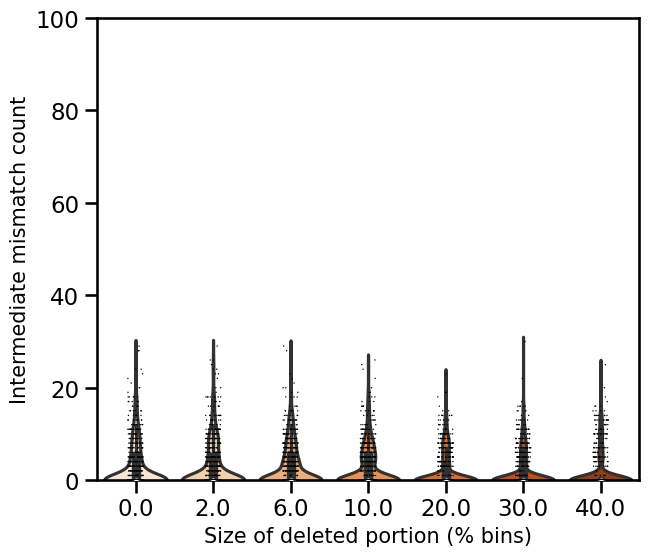

In [65]:
df['intermediate_mm_count'] = df['intermediate_mm_count'].astype('float')
sb.set_context("talk")
with plt.rc_context({'figure.figsize':[7,6]}):

    sb.violinplot(x= 'size', y='intermediate_mm_count', data= df, cut=True, scale='width', palette='Oranges')
    sb.stripplot(data=df, x='size', y='intermediate_mm_count', color='black', s=1);
    plt.ylabel('Intermediate mismatch count', fontsize=15)
    plt.xlabel('Size of deleted portion (% bins)',  fontsize=15)
    plt.ylim(0,100.0);
    plt.savefig('simexp2_new_deletePerturb_mm_counts2.png')

### Plotting heatmap of z-normalised interpolated gene expression of the entire data (no perturbation)

In [109]:
adata = adata[:,adata_ref.var_names]

In [112]:
gene_list= list(adata_ref.var_names) 
aligner = Main.RefQueryAligner(adata, adata, gene_list, 50)
aligner.WEIGHT_BY_CELL_DENSITY = True
aligner.WINDOW_SIZE=0.1
aligner.align_all_pairs()

adata_ref = adata
adata_query = adata 

Interpolated mean trends


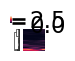

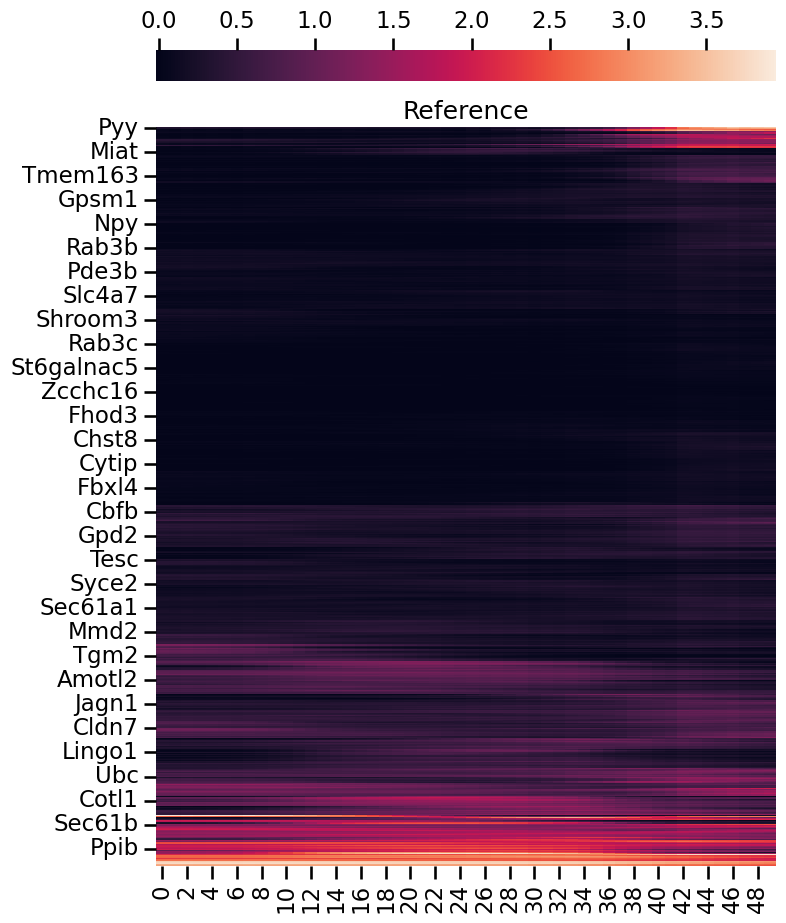

Z-normalised Interpolated mean trends


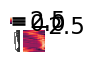

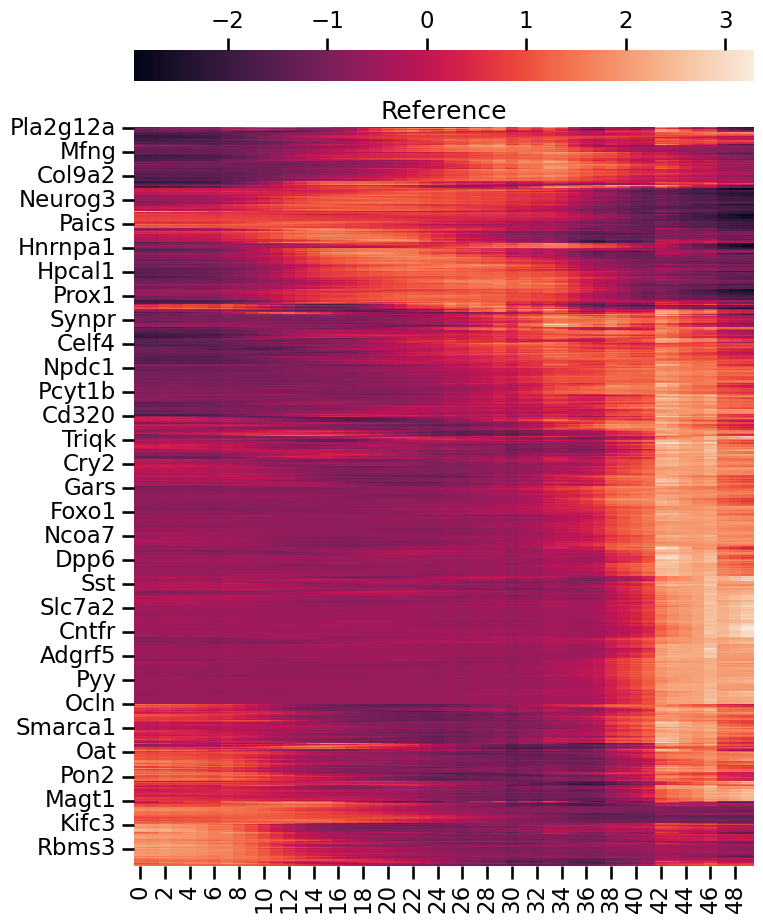

In [138]:
# Let's pick the pathways of interest from the above list and check their alignment statistics
from gsea_api.molecular_signatures_db import MolecularSignaturesDatabase
from adjustText import adjust_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import zscore

class InterestingGeneSets:
    
    def __init__(self):        
        self.SETS = {}
        self.dbs = {}
        self.msigdb = MolecularSignaturesDatabase('../../msigdb', version='7.5.1')
        self.dbs['kegg'] = self.msigdb.load('c2.cp.kegg', 'symbols')
        self.dbs['hallmark'] = self.msigdb.load('h.all', 'symbols')
        self.dbs['gobp'] = self.msigdb.load('c5.go.bp', 'symbols')
        self.dbs['gocc'] = self.msigdb.load('c5.go.cc', 'symbols')
        self.dbs['reac'] = self.msigdb.load('c2.cp.reactome', 'symbols')
        
    def add_new_set_from_msigdb(self, db_name, dbsetname, avail_genes, usersetname):
        self.SETS[usersetname] = np.intersect1d(list(self.dbs[db_name].gene_sets_by_name[dbsetname].genes), avail_genes)

    def add_new_set(self, geneset, usersetname, avail_genes):
        geneset = np.asarray(geneset)
        self.SETS[usersetname] = geneset[np.where([g in avail_genes for g in geneset])]

def plot_heatmaps(mat_ref,mat_query,pathway_name, cluster=False):
    
    if(cluster):
        g=sb.clustermap(mat_ref, figsize=(0.4,0.4), col_cluster=False) 
        gene_order = g.dendrogram_row.reordered_ind
        #print(len(gene_order)) 
        df = pd.DataFrame(g.data2d) 
        #print(IGS.SETS[pathway_name])
        df.index = np.asarray(IGS.SETS[pathway_name])[gene_order]
    else:
        df=mat_ref
    
    plt.subplots(1,1,figsize=(8,12))
    max_val = np.max([np.max(mat_ref),np.max(mat_query)]) 
    min_val = np.min([np.min(mat_ref),np.min(mat_query)]) 
    plt.subplot(1,1,1)
    ax=sb.heatmap(df, vmax=max_val,vmin=min_val, cbar_kws = dict(use_gridspec=False,location="top")) 
    plt.title('Reference')
    ax.yaxis.set_label_position("left")
    for tick in ax.get_yticklabels():
        tick.set_rotation(360)
    plt.savefig('simexp2_reference_genes_heatmap.png', bbox_inches='tight')
    plt.show()
    
    
# smoothened/interpolated mean trends + Z normalisation 
def plot_mean_trend_heatmaps(pathway_name, cluster=False):
    S_mat = []
    T_mat = []
    S_zmat = []
    T_zmat = []

    for gene in IGS.SETS[pathway_name]:

        fS = pd.DataFrame([aligner.results_map[gene].S.mean_trend, np.repeat('Ref', len(aligner.results_map[gene].S.mean_trend))]).transpose()
        fT = pd.DataFrame([aligner.results_map[gene].T.mean_trend, np.repeat('ATO', len(aligner.results_map[gene].T.mean_trend))]).transpose()
        f = pd.concat([fS,fT])
        f[0] = np.asarray(f[0], dtype=np.float64)
        from scipy.stats import zscore
        f['z_normalised'] = zscore(f[0])
        S_mat.append(np.asarray(f[f[1]=='Ref'][0]))
        T_mat.append(np.asarray(f[f[1]=='ATO'][0]))    
        S_zmat.append(np.asarray(f[f[1]=='Ref']['z_normalised']))
        T_zmat.append(np.asarray(f[f[1]=='ATO']['z_normalised']))  
    S_mat = pd.DataFrame(S_mat)
    T_mat = pd.DataFrame(T_mat)
    S_zmat = pd.DataFrame(S_zmat)
    T_zmat = pd.DataFrame(T_zmat)
    
    S_mat.index = IGS.SETS[pathway_name]
    T_mat.index = IGS.SETS[pathway_name]
    S_zmat.index = IGS.SETS[pathway_name]
    T_zmat.index = IGS.SETS[pathway_name]
    
    print('Interpolated mean trends')
    plot_heatmaps(S_mat, T_mat, pathway_name, cluster=cluster)
    print('Z-normalised Interpolated mean trends')
    return plot_heatmaps(S_zmat, T_zmat, pathway_name,cluster=cluster)

IGS = InterestingGeneSets()
IGS.SETS['all_genes'] = aligner.gene_list
plot_mean_trend_heatmaps('all_genes',cluster=True) 

In [145]:
# write alignment results tables
def write_table(aligner, dataset_id):
    df = []
    for g in aligner.gene_list:
        al_obj = aligner.results_map[g]
        df.append([g, al_obj.alignment_str, al_obj.get_series_match_percentage()[0]] )
    df = pd.DataFrame(df)
    df.columns = ['Gene','5-state alignment string','Alignment similarity %']
    df.to_csv('simexp2_supplementary_tables/'+dataset_id+'gene_alignments.csv')
    return df

write_table(aligners['I_size0'], 'I_size0')
write_table(aligners['I_size1'], 'I_size1')
write_table(aligners['I_size3'], 'I_size3')
write_table(aligners['I_size5'], 'I_size5')
write_table(aligners['I_size10'], 'I_size10')
write_table(aligners['I_size15'], 'I_size15')
write_table(aligners['I_size20'], 'I_size20')
write_table(aligners['D_size0'], 'D_size0')
write_table(aligners['D_size1'], 'D_size1')
write_table(aligners['D_size3'], 'D_size3')
write_table(aligners['D_size5'], 'D_size5')
write_table(aligners['D_size10'], 'D_size10')
write_table(aligners['D_size15'], 'D_size15')
write_table(aligners['D_size20'], 'D_size20')

,Gene,5-state alignment string,Alignment similarity %
0,Uggt1,IIIDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,88.68
1,Fhl2,IIDDDDDDDDDDDDDDDDDDMMMMMMMMMVVVVVVVVVVVVVVVVM...,70.59
2,Pgap1,IIIIIIIIIIIIDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMM...,56.72
3,Fev,DDDDDDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,86.21
4,Cryba2,IIIDDDDDDDDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,78.33
...,...,...,...
764,Map3k15,DDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMMMMMMMVVVVVVVV...,76.92
765,Rai2,DDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,92.59
766,Rbbp7,DDDDDDDDDDDDDDDDMMMMMMVVVVVVVVVVVVVVVVMMMMMMMM...,75.76
767,Ap1s2,IIDWWWWWWWWWWWWWWWWWWWWIIIIIIIIIIIIIIIMMMMMMMM...,74.65
